In [1]:
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# Matplotlif config
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.metrics import accuracy_score, recall_score, \
    precision_score, f1_score, roc_auc_score, log_loss, \
    confusion_matrix, plot_confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from scipy.stats import uniform, reciprocal
# Save images
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

# Multiple outpunts shown
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Data

## Loading

In [2]:
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "Data", "Input")

def load_data(data_path=DATA_PATH, file_name='diabetic_data.csv'):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path)

In [3]:
from sklearn.model_selection import train_test_split

data = load_data()

## Getting to know the data

### General info

In [4]:
data.sample(5).T

,58174,61057,15193,72150,84010
encounter_id,165104796,170674902,58510128,210600396,264018372
patient_nbr,23659110,85922757,1432161,94072113,40874013
race,AfricanAmerican,Caucasian,Caucasian,AfricanAmerican,Caucasian
gender,Female,Female,Female,Male,Female
age,[60-70),[80-90),[40-50),[30-40),[80-90)
weight,?,?,?,?,?
admission_type_id,1,1,2,1,3
discharge_disposition_id,6,1,18,1,6
admission_source_id,7,7,1,7,1
time_in_hospital,4,3,3,1,11


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

At first glance, there is no missing data. But given the data description we know this is not that case and we have missing data in race, weight, payer_code, medical_specialty and diag_3 columns. 

In [6]:
data[['race', 'weight', 'payer_code', 'medical_specialty', 'diag_3']]\
    .sample(5)

,race,weight,payer_code,medical_specialty,diag_3
69736,Caucasian,?,?,?,427
9468,Other,?,?,?,263
63568,Caucasian,?,MC,?,401
53237,Caucasian,?,BC,?,311
31837,?,?,BC,Orthopedics-Reconstructive,998


Missing values seem to be coded with question marks

In [7]:
# For test results, a 'None' indicates that no test was taken. I'll also take this as
# a null value, even if it's most likely that I'll revert this at some point
data[['max_glu_serum', 'A1Cresult']]\
    .sample(5)

,max_glu_serum,A1Cresult
65473,None,None
44140,None,None
93749,None,None
85730,None,None
17017,None,Norm


In [8]:
# encounter_id is our unique row identifier, each is unique
# patients can be registered multiple timesin the dataset
data\
    .agg({
    'encounter_id': ['count', 'nunique'],
    'patient_nbr': ['count', 'nunique']
})

,encounter_id,patient_nbr
count,101766,101766
nunique,101766,71518


In [9]:
# The patient with most entries has 40 observations.
num_obs = data\
    [['encounter_id', 'patient_nbr']]\
    .groupby('patient_nbr', as_index=False)\
    .count()\
    .rename({'encounter_id': 'n_entries'}, axis='columns')\
    .assign(multiple_obs = lambda r:( r.n_entries >1).astype(int))


num_obs\
    .sort_values('n_entries', ascending=False)\
    .head()

,patient_nbr,n_entries,multiple_obs
54474,88785891,40,1
32927,43140906,28,1
3515,1660293,23,1
17018,23199021,23,1
54057,88227540,23,1


In [10]:
num_obs\
    .groupby('multiple_obs')\
    [['patient_nbr']]\
    .count()

,patient_nbr
multiple_obs,
0,54745
1,16773


In [11]:
num_obs\
    .groupby('multiple_obs')\
    [['patient_nbr']]\
    .count()\
    .div(len(num_obs))

,patient_nbr
multiple_obs,
0,0.765472
1,0.234528


In [12]:
data\
    .groupby('readmitted')\
    [['encounter_id']]\
    .count()

,encounter_id
readmitted,
<30,11357
>30,35545
NO,54864


In [13]:
data\
    .groupby('readmitted')\
    [['encounter_id']]\
    .count()\
    .div(len(data))

,encounter_id
readmitted,
<30,0.111599
>30,0.349282
NO,0.539119


In [14]:
data\
    .merge(num_obs, on=['patient_nbr'], how='left')\
    .groupby(['readmitted', 'multiple_obs'])\
    [['encounter_id']]\
    .count()

encounter_id
readmitted multiple_obs              
<30        0                     2166
           1                     9191
>30        0                     9878
           1                    25667
NO         0                    42701
           1                    12163

The readmitted variable doesn't seem to map very well with if we observe multiple times a patient in our data.

In [15]:
mult_non_readm = data\
    .loc[lambda r: r.readmitted == 'NO']\
    .groupby('patient_nbr', as_index=False)\
    [['encounter_id']]\
    .count()\
    .loc[lambda r: r.encounter_id > 1]

mult_non_readm\
    .count()

patient_nbr     44
encounter_id    44
dtype: int64

There are 44 cases where we have multiple instances of a patient not being readmitted more than once. This doensn't make sense

In [16]:
data\
    .merge(mult_non_readm[['patient_nbr']], on=['patient_nbr'], how='inner')\
    .loc[:, ['patient_nbr', 'readmitted']]\
    .head(5)


,patient_nbr,readmitted
0,23778297,NO
1,23778297,NO
2,18627624,NO
3,18627624,NO
4,1305612,NO


In [17]:
readmitted_oneobs = data\
    .merge(num_obs, on=['patient_nbr'], how='left')\
    .loc[
        lambda r: (r.multiple_obs == 0) & (r.readmitted != 'NO')]\
    .patient_nbr.drop_duplicates()



len(readmitted_oneobs)

12044

There are also 12k cases where we have register of readmittion but not the observations of this readmittions. This can be caused by exclusion of some hospitalizations if this are shorter than 1 day, or longer than 14. So no data error is assumed in this case

In [18]:
data\
    .time_in_hospital\
    .agg(['min', 'max'])

min     1
max    14
Name: time_in_hospital, dtype: int64

We have availabe codes for different diagnosis groups, it might be a good idea to decode this groups as a feature

In [19]:
# change 1
# Decoding diagnosis
def decode_diag(r, col):
    return np.select(
        [
            ((r[col]>='390') & (r[col]<='459')) | (r[col] == '785'),
            ((r[col]>='460') & (r[col]<='519')) | (r[col] == '786'),
            ((r[col]>='520') & (r[col]<='579')) | (r[col] == '787'),
            ((r[col]>='580') & (r[col]<='629')) | (r[col] == '788'),
            ((r[col]>='680') & (r[col]<='709')) | (r[col] == '782'),
            (r[col]>='800') & (r[col]<='999'),
            (r[col]>='710') & (r[col]<='739'),
            (r[col]>='250') & (r[col]<'251'),
            (r[col]>='140') & (r[col]<'239'),
            (r[col]>='240') & (r[col]<'279'),
            r[col].isnull()
        ],
        [
            'Circulatory',
            'Respiratory',
            'Digestive',
            'Genitourinaty',
            'Skin',
            'Injury',
            'Musculoskeleteal',
            'Diabetes',
            'Noeplasms',
            'Metabolic',
            np.nan
        ],
        'Other')

data = data\
    .assign(
    diag_group_1 = lambda r: decode_diag(r, 'diag_1'),    
    diag_group_2 = lambda r: decode_diag(r, 'diag_2'),
    diag_group_3 = lambda r: decode_diag(r, 'diag_3'))



In [20]:
# Change 2
# Binary deffinition of readmission

data = data.assign(readmission = lambda r: (r.readmitted == '<30').astype(int))

In [21]:
diag_groups = [
    'Circulatory', 'Respiratory', 'Digestive', 'Genitourinaty', 'Skin',
    'Injury', 'Musculoskeleteal', 'Diabetes', 'Noeplasms', 'Metabolic',
    'Other']

In [22]:
# Change 3
# One hot encoding for diagnosis groups
for diag in diag_groups:
    data[diag] = ((data['diag_group_1'] == diag) | (data['diag_group_2'] == diag) | (data['diag_group_3'] == diag)).astype(int)

### Identifying column types

In [23]:
g = data.columns.to_series().groupby(data.dtypes).groups
column_types = {k.name: v for k, v in g.items()}
column_types

{'int32': Index(['readmission', 'Circulatory', 'Respiratory', 'Digestive',
        'Genitourinaty', 'Skin', 'Injury', 'Musculoskeleteal', 'Diabetes',
        'Noeplasms', 'Metabolic', 'Other'],
       dtype='object'),
 'int64': Index(['encounter_id', 'patient_nbr', 'admission_type_id',
        'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
        'num_lab_procedures', 'num_procedures', 'num_medications',
        'number_outpatient', 'number_emergency', 'number_inpatient',
        'number_diagnoses'],
       dtype='object'),
 'object': Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
        'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
        'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
        'tolazamide', 'examide', 'citoglipton', 'insulin',

In [24]:
id_cols = ['encounter_id', 'patient_nbr']
nominal_categorical = [
    # See id_mapping.csv for a dictionary on this variables
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
    # Patient general info
    'race', 'gender', 
    # Hospitalization info
    'payer_code', 'medical_specialty',
    # Diagnosis codes
    'diag_1', 'diag_2', 'diag_3', 'diag_group_1', 'diag_group_2', 'diag_group_3',
    # Diagnosis groups
    *diag_groups,
    # medications
    # medication general info
    'change', 'diabetesMed',
    # Specific medications
    'metformin', 'repaglinide', 'nateglinide',
    'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]
ordinal_categorical = [
    # Patient general info
    'age', 'weight',
    # Test results
    'max_glu_serum', 'A1Cresult'

]
numerical = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
    'num_medications', 'number_outpatient', 'number_emergency', 
    'number_inpatient', 'number_diagnoses']

target =[ 'readmitted', 'readmission']

cols = [
    *id_cols, *nominal_categorical, *ordinal_categorical, *numerical, *target]



### Categorical variables

Lets print the 3 most common categories for each variable

In [25]:
for var in nominal_categorical:
    data[var].value_counts(dropna=False)\
    .div(len(data)).mul(100).round(1).astype(str).add('%')[:3]

1    53.1%
3    18.5%
2    18.2%
Name: admission_type_id, dtype: object

1    59.2%
3    13.7%
6    12.7%
Name: discharge_disposition_id, dtype: object

7     56.5%
1     29.1%
17     6.7%
Name: admission_source_id, dtype: object

Caucasian          74.8%
AfricanAmerican    18.9%
?                   2.2%
Name: race, dtype: object

Female             53.8%
Male               46.2%
Unknown/Invalid     0.0%
Name: gender, dtype: object

?     39.6%
MC    31.9%
HM     6.2%
Name: payer_code, dtype: object

?                   49.1%
InternalMedicine    14.4%
Emergency/Trauma     7.4%
Name: medical_specialty, dtype: object

428    6.7%
414    6.5%
786    3.9%
Name: diag_1, dtype: object

276    6.6%
428    6.5%
250    6.0%
Name: diag_2, dtype: object

250    11.4%
401     8.1%
276     5.1%
Name: diag_3, dtype: object

Circulatory    30.0%
Respiratory    14.2%
Other          12.4%
Name: diag_group_1, dtype: object

Circulatory    31.8%
Other          14.0%
Diabetes       12.6%
Name: diag_group_2, dtype: object

Circulatory    30.5%
Other          17.5%
Diabetes       16.9%
Name: diag_group_3, dtype: object

1    59.3%
0    40.7%
Name: Circulatory, dtype: object

0    73.6%
1    26.4%
Name: Respiratory, dtype: object

0    85.8%
1    14.2%
Name: Digestive, dtype: object

0    82.5%
1    17.5%
Name: Genitourinaty, dtype: object

0    92.0%
1     8.0%
Name: Skin, dtype: object

0    90.1%
1     9.9%
Name: Injury, dtype: object

0    92.6%
1     7.4%
Name: Musculoskeleteal, dtype: object

0    62.6%
1    37.4%
Name: Diabetes, dtype: object

0    94.1%
1     5.9%
Name: Noeplasms, dtype: object

0    81.7%
1    18.3%
Name: Metabolic, dtype: object

0    64.7%
1    35.3%
Name: Other, dtype: object

No    53.8%
Ch    46.2%
Name: change, dtype: object

Yes    77.0%
No     23.0%
Name: diabetesMed, dtype: object

No        80.4%
Steady    18.0%
Up         1.0%
Name: metformin, dtype: object

No        98.5%
Steady     1.4%
Up         0.1%
Name: repaglinide, dtype: object

No        99.3%
Steady     0.7%
Up         0.0%
Name: nateglinide, dtype: object

No        99.9%
Steady     0.1%
Up         0.0%
Name: chlorpropamide, dtype: object

No        94.9%
Steady     4.6%
Up         0.3%
Name: glimepiride, dtype: object

No        100.0%
Steady      0.0%
Name: acetohexamide, dtype: object

No        87.5%
Steady    11.2%
Up         0.8%
Name: glipizide, dtype: object

No        89.5%
Steady     9.1%
Up         0.8%
Name: glyburide, dtype: object

No        100.0%
Steady      0.0%
Name: tolbutamide, dtype: object

No        92.8%
Steady     6.9%
Up         0.2%
Name: pioglitazone, dtype: object

No        93.7%
Steady     6.0%
Up         0.2%
Name: rosiglitazone, dtype: object

No        99.7%
Steady     0.3%
Up         0.0%
Name: acarbose, dtype: object

No        100.0%
Steady      0.0%
Down        0.0%
Name: miglitol, dtype: object

No        100.0%
Steady      0.0%
Name: troglitazone, dtype: object

No        100.0%
Steady      0.0%
Up          0.0%
Name: tolazamide, dtype: object

No    100.0%
Name: examide, dtype: object

No    100.0%
Name: citoglipton, dtype: object

No        46.6%
Steady    30.3%
Down      12.0%
Name: insulin, dtype: object

No        99.3%
Steady     0.7%
Up         0.0%
Name: glyburide-metformin, dtype: object

No        100.0%
Steady      0.0%
Name: glipizide-metformin, dtype: object

No        100.0%
Steady      0.0%
Name: glimepiride-pioglitazone, dtype: object

No        100.0%
Steady      0.0%
Name: metformin-rosiglitazone, dtype: object

No        100.0%
Steady      0.0%
Name: metformin-pioglitazone, dtype: object

In [26]:
for var in ordinal_categorical:
    data[var].value_counts(dropna=False)\
    .div(len(data)).mul(100).round(1).astype(str).add('%')[:5]

[70-80)    25.6%
[60-70)    22.1%
[50-60)    17.0%
[80-90)    16.9%
[40-50)     9.5%
Name: age, dtype: object

?            96.9%
[75-100)      1.3%
[50-75)       0.9%
[100-125)     0.6%
[125-150)     0.1%
Name: weight, dtype: object

None    94.7%
Norm     2.6%
>200     1.5%
>300     1.2%
Name: max_glu_serum, dtype: object

None    83.3%
>8       8.1%
Norm     4.9%
>7       3.7%
Name: A1Cresult, dtype: object

The following variables might not be very informative because their most common category has above 99% incidence

In [27]:
homogeneous_vars = []
for var in [*ordinal_categorical, *nominal_categorical]:
    if data[var].value_counts(dropna=False).div(len(data)).iloc[0] > .99:
        print(var)
        homogeneous_vars.append(var)

nateglinide
chlorpropamide
acetohexamide
tolbutamide
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone


All of them are specific medicine variables. This are medicines that are rare/

In [28]:
data\
    [('No' != data[homogeneous_vars]).sum(axis=1).astype(bool)]\
    ['diabetesMed']\
    .value_counts()

Yes    1910
Name: diabetesMed, dtype: int64

And as expected, all cases where this medicines are present, this is registered on the diabetesMed column

#### Information on each categorical variable

In [29]:
from scipy.stats import entropy

In [30]:
chance_of_readmission = data\
    ['readmission']\
    .mean()
qk = [chance_of_readmission, 1-chance_of_readmission]

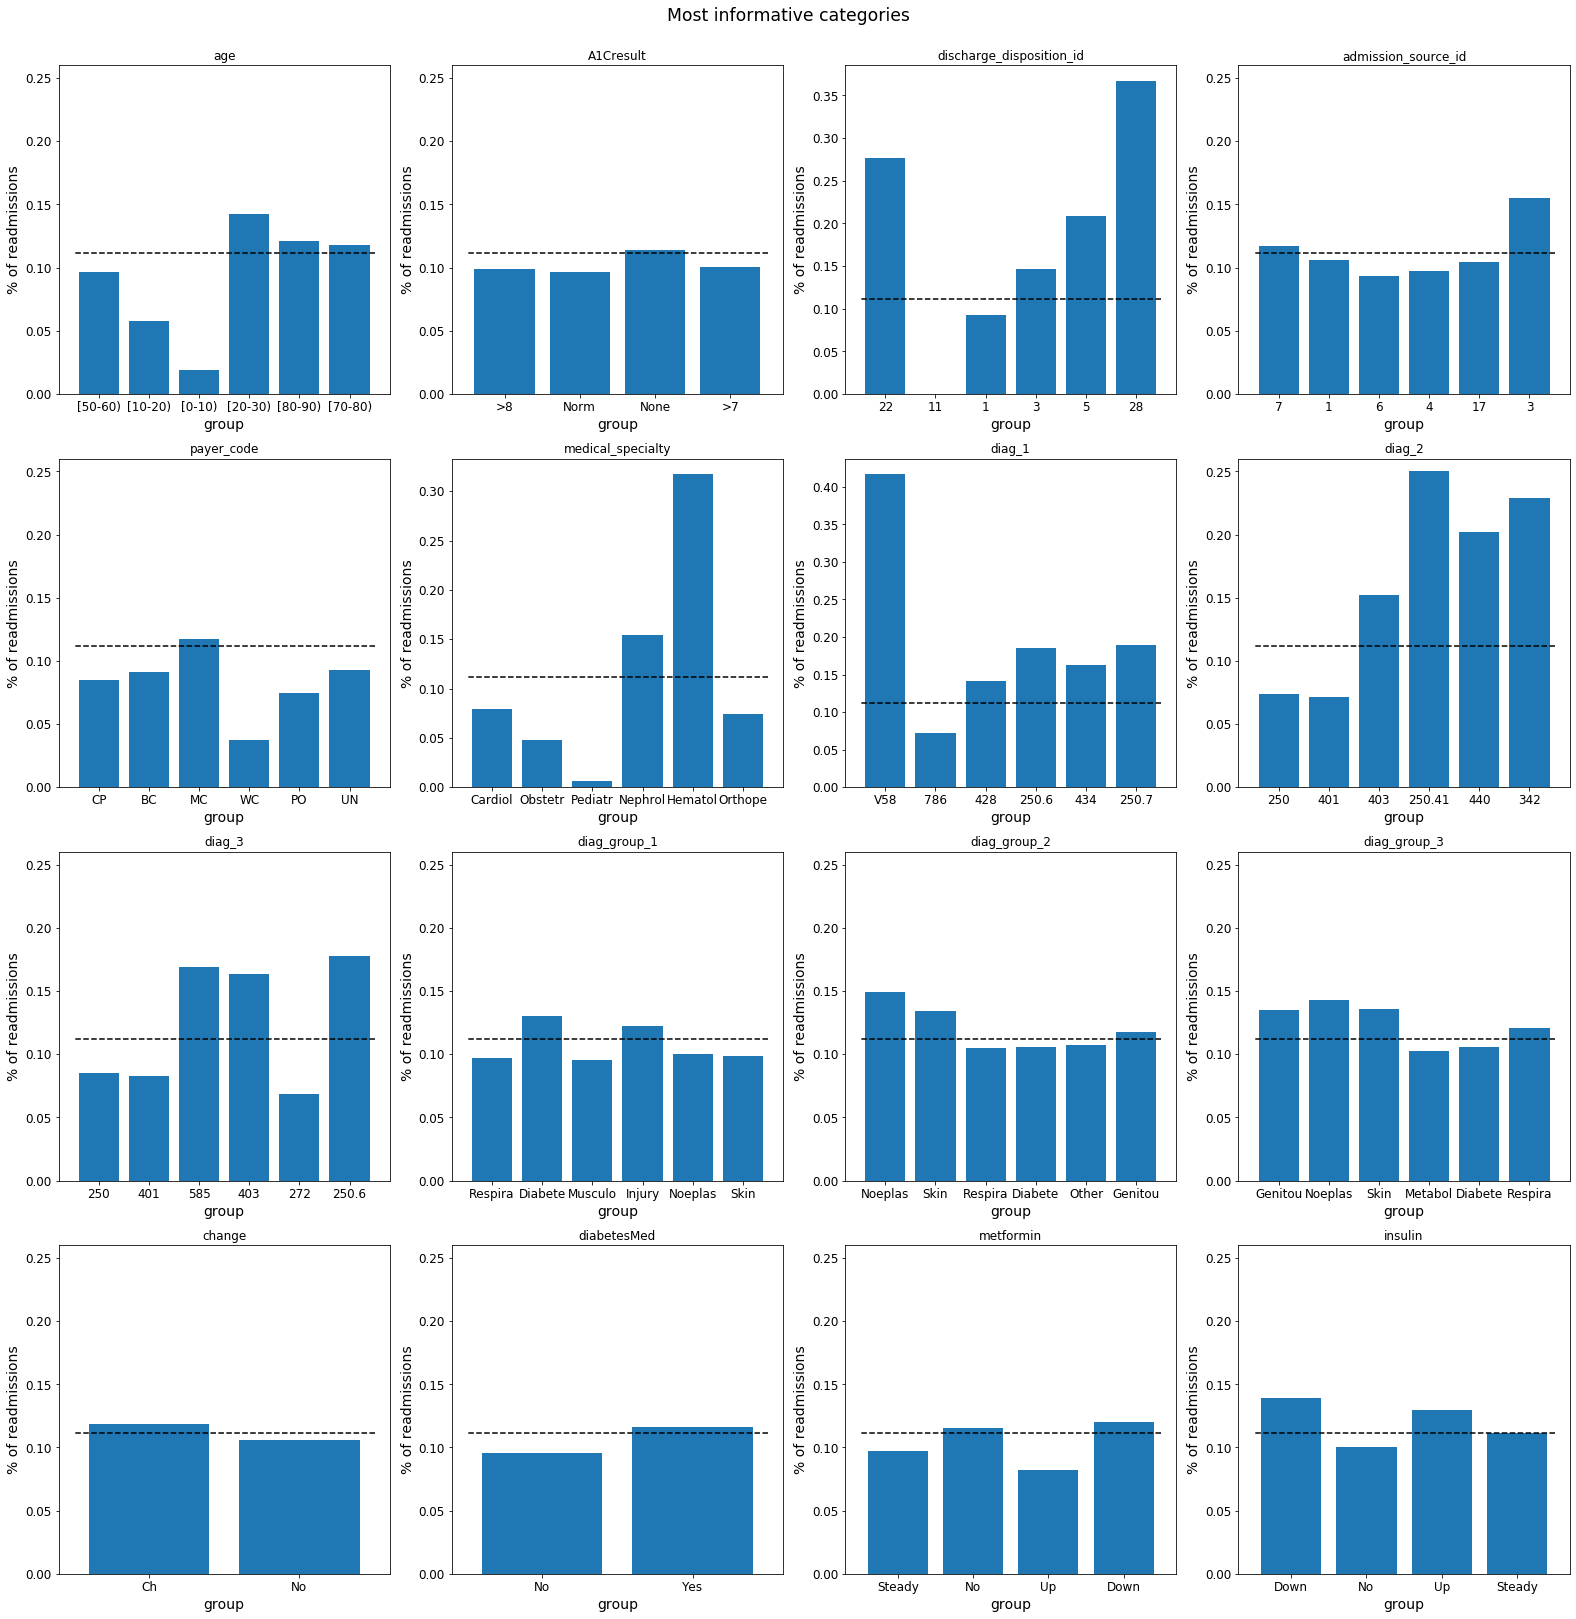

In [31]:
entropies = {}
important_groups = {}

f, axs = plt.subplots(4, 4)
j = 0
f.set_figheight(22)
f.set_figwidth(22)

for var in [*ordinal_categorical, *nominal_categorical]: 
    a = data\
            [[var, 'readmission']]\
            .groupby(var, dropna=False)\
            .agg([('pct_readmitted', 'mean'), ('pct_cases', 'count')])\
            .droplevel(level=0, axis=1)\
            .assign(
                pct_cases = lambda r: r.pct_cases / len(data))

    kl_div = []
    for i in a.index:
        kl_div.append(
            entropy([a.loc[i, 'pct_readmitted'], 1-a.loc[i, 'pct_readmitted']], qk))

    a['kl_div'] = kl_div
    a = a\
            .assign(kl_div = lambda r: r.kl_div * r.pct_cases)
    entropy_var = a\
            .kl_div.sum()
    entropies[var] = entropy_var
    vizdata = a.reset_index().sort_values('kl_div', ascending=False).head(6).fillna('NA')

    if vizdata.kl_div.sum() > 0.00016:
        x = vizdata[var].astype(str).str[:7]
        y = vizdata['pct_readmitted']
        ax = axs[j//4, j % 4]
        bar = ax.bar(x, y)
        title = ax.set_title(var)
        ylabel = ax.set_ylabel('% of readmissions')
        xlabel = ax.set_xlabel('group')
        hline = ax.hlines(chance_of_readmission, len(vizdata)-.5, -.5, linestyles='dashed')
        if 'diag' not in var:
            important_groups[var] = vizdata[var].to_list()
        if y.max() < .26:
            ylim=ax.set_ylim(0, 0.26)
        j+=1

suptitle = f.suptitle("Most informative categories", y = 1.02, size = 'xx-large')
f.tight_layout()
plt.show()

In [32]:
# Variables sorted by class-weighted average Kullback–Leibler divergence
most_infoirmative_vars = pd.DataFrame(
    pd.Series(entropies).sort_values(ascending=False), 
    columns=['K-L divergnece'])
most_infoirmative_vars.head(16).mul(100).round(2).astype(str).add('%')

,K-L divergnece
diag_1,0.85%
diag_3,0.76%
discharge_disposition_id,0.76%
diag_2,0.71%
medical_specialty,0.18%
insulin,0.09%
age,0.06%
payer_code,0.05%
diag_group_1,0.05%
diag_group_3,0.05%


In [33]:
important_diag_groups = most_infoirmative_vars\
    .loc[diag_groups]\
    .sort_values('K-L divergnece', ascending=False)\
    .mul(100).round(3).astype(str).add('%')
important_diag_groups

,K-L divergnece
Genitourinaty,0.011%
Skin,0.008%
Musculoskeleteal,0.006%
Respiratory,0.005%
Noeplasms,0.004%
Injury,0.004%
Diabetes,0.001%
Metabolic,0.001%
Circulatory,0.0%
Digestive,0.0%


In [34]:
# Reducing categories to only the most important ones
for cat in important_groups:
    data[cat] = np.where(
        data[cat].isin(important_groups[cat]),
        data[cat], 'OTHER')

In [35]:
selected_categorical = list(important_groups.keys()) + important_diag_groups.head(7).index.to_list()
# selected_categorical_onehot = [l for l in one_hot_df.columns.to_list() if '_no' not in l.lower()] + important_diag_groups.head(7).index.to_list()

In [36]:
data[selected_categorical]

,age,A1Cresult,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,change,diabetesMed,metformin,insulin,Genitourinaty,Skin,Musculoskeleteal,Respiratory,Noeplasms,Injury,Diabetes
0,[0-10),None,OTHER,1,OTHER,Pediatrics-Endocrinology,No,No,No,No,0,0,0,0,0,0,1
1,[10-20),None,1,7,OTHER,OTHER,Ch,Yes,No,Up,0,0,0,0,0,0,1
2,[20-30),None,1,7,OTHER,OTHER,No,Yes,No,No,0,0,0,0,0,0,1
3,OTHER,None,1,7,OTHER,OTHER,Ch,Yes,No,Up,0,0,0,0,0,0,1
4,OTHER,None,1,7,OTHER,OTHER,Ch,Yes,No,Steady,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,[70-80),>8,3,7,MC,OTHER,Ch,Yes,Steady,Down,0,0,0,0,0,0,1
101762,[80-90),None,OTHER,OTHER,MC,OTHER,No,Yes,No,Steady,0,0,0,0,0,0,0
101763,[70-80),None,1,7,MC,OTHER,Ch,Yes,Steady,Down,1,0,0,0,0,0,0
101764,[80-90),None,3,7,MC,OTHER,Ch,Yes,No,Up,0,0,0,0,0,1,0


This are the most informative variables on their own (not considering interactions). 6 Of them are diagnosis variables, and the others are discharge disposition, medical speciality, payer code and admission_source_id (which give us information about the conditions of the hospitalization), age (information about the patient) and insulin, mtformin, change and diabetesMed (which give us information about the treatment)  
Blood test A1Cresult is the 16th most informative variable. Not great.

TODO:  
Patients who took A1C test during hospitalizatons were less likely to be readmitted in less than 30 days, regardless of test result. Why?

### Numerical variables

In [37]:
data[[*numerical, 'readmission']].describe().round(1)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmission
count,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0
mean,4.4,43.1,1.3,16.0,0.4,0.2,0.6,7.4,0.1
std,3.0,19.7,1.7,8.1,1.3,0.9,1.3,1.9,0.3
min,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
25%,2.0,31.0,0.0,10.0,0.0,0.0,0.0,6.0,0.0
50%,4.0,44.0,1.0,15.0,0.0,0.0,0.0,8.0,0.0
75%,6.0,57.0,2.0,20.0,0.0,0.0,1.0,9.0,0.0
max,14.0,132.0,6.0,81.0,42.0,76.0,21.0,16.0,1.0


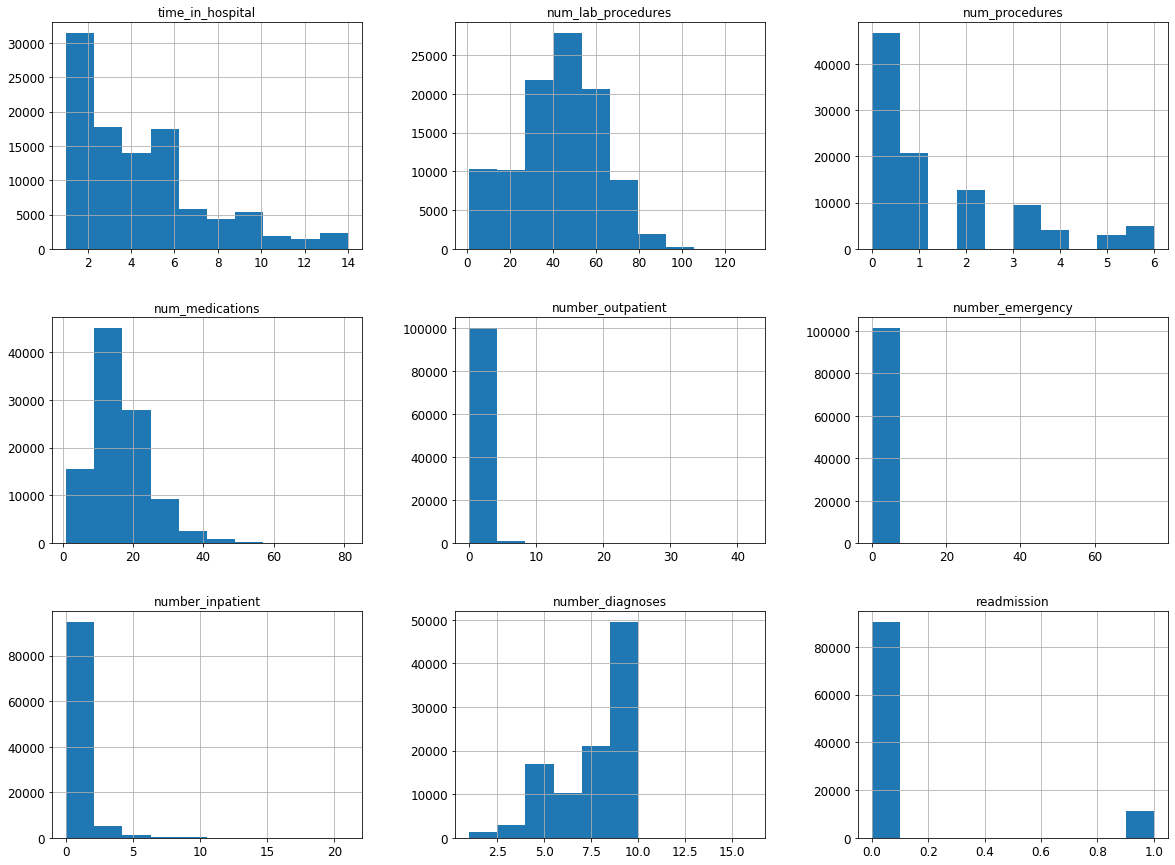

In [38]:
histogram = data[[*numerical, 'readmission']].hist(bins=10, figsize=(20,15))

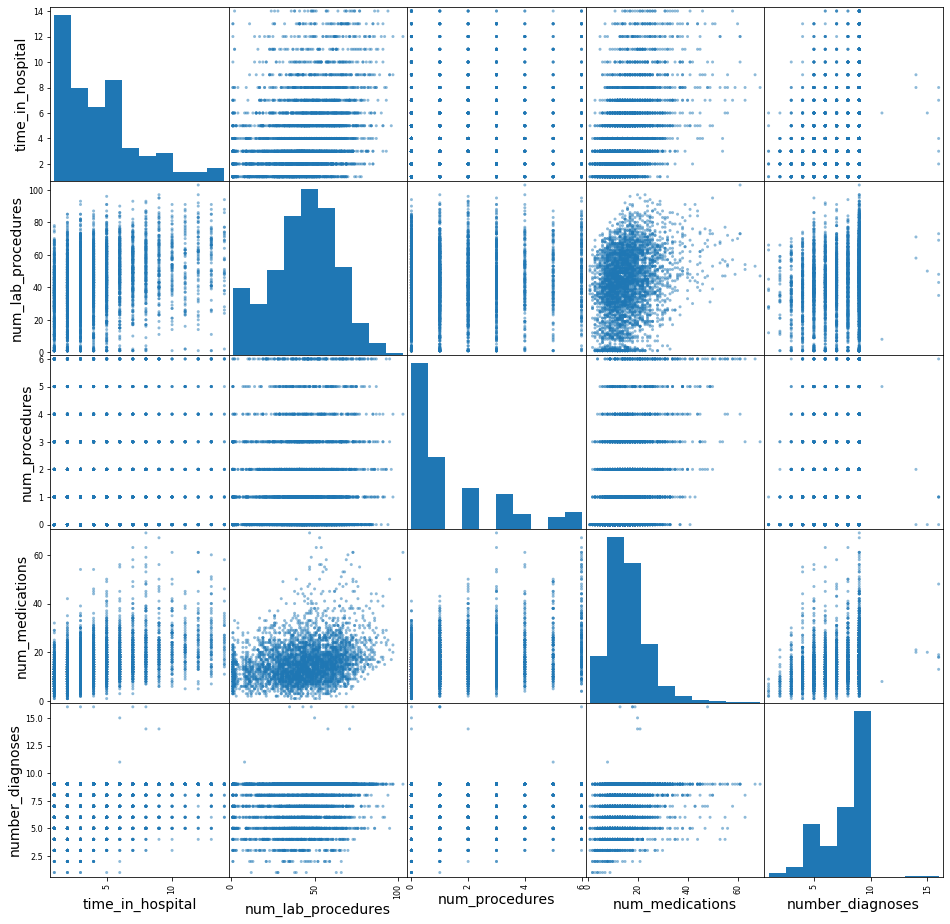

In [39]:
from pandas.plotting import scatter_matrix

scatter = scatter_matrix(data[['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_diagnoses']].sample(len(data) // 25), figsize=(16, 16))

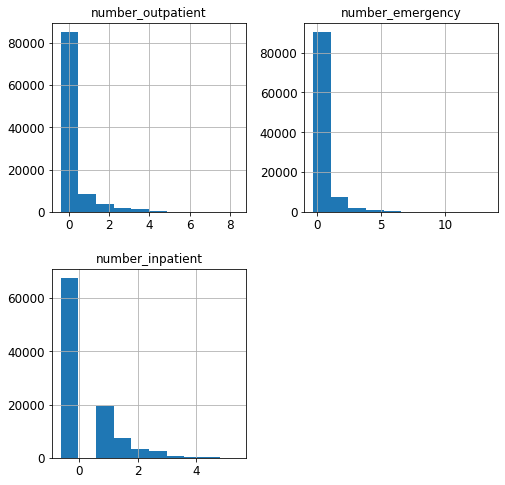

In [40]:
skewed_vars = ['number_outpatient', 'number_emergency', 'number_inpatient']
logtransf = np.log10(data[skewed_vars] + 1)
logtransf = logtransf.sub(logtransf.mean()).div(logtransf.std())
foo = logtransf.hist(bins=10, figsize=(8,8))

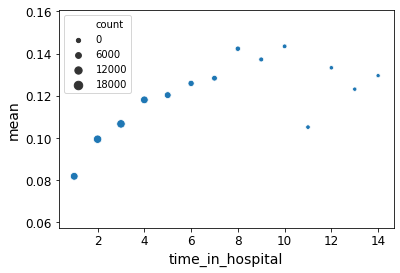

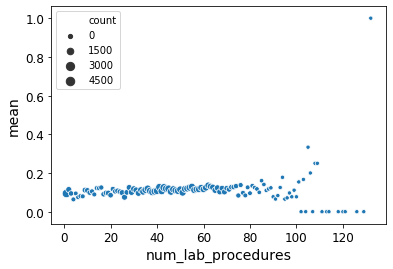

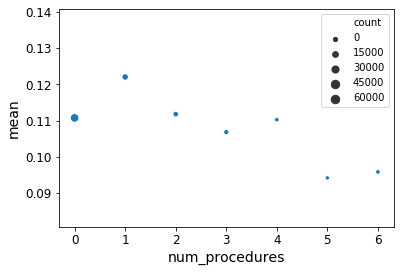

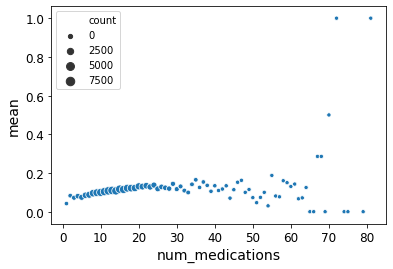

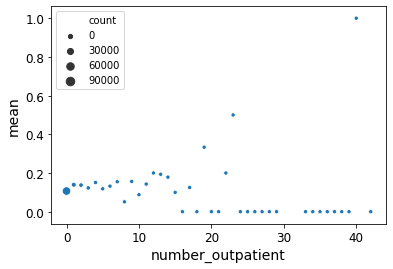

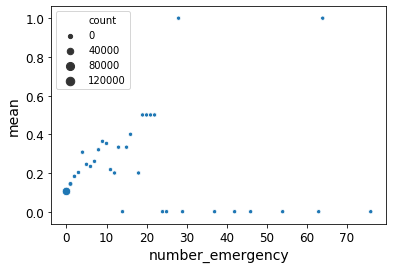

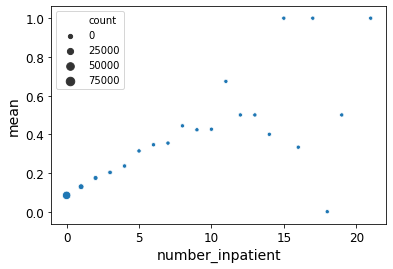

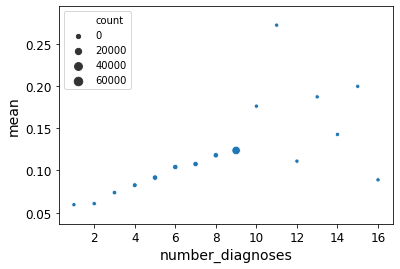

In [41]:
for var in numerical:
    vizdata = data\
        .groupby(var)\
        ['readmission']\
        .agg(['mean', 'count'])\
        .reset_index()
    numer_plot = sns.scatterplot(data=vizdata, x=var, y='mean', size='count')
    plt.show()
    

TODO: HAcer la normalizacion con pipeline para poder hacer transformaciones sobre datos nuevos

## Preparing the data for the model

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

In [45]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=70)

In [52]:
drop_group_list = ['OTHER', 'None', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'No', 'No', 'No', 'No', 0, 0, 0, 0, 0, 0, 0]

data_pipeline = ColumnTransformer([
    ('num', PowerTransformer(method='yeo-johnson', standardize=True), numerical),
    ('cat', OneHotEncoder(drop=drop_group_list, handle_unknown='ignore'), selected_categorical)
])

data_prepared = data_pipeline.fit_transform(train_data.drop('readmission', axis=1))
labels = train_data["readmission"].copy()

test_data_prepared = data_pipeline.transform(test_data.drop('readmission', axis=1))
test_labels = test_data["readmission"].copy()

## Model

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import geom

param_distribs = {
        'n_estimators': reciprocal.rvs(a=2**4,b=2**10, size=1000).astype(int),
        'min_samples_leaf': reciprocal.rvs(a=2**0,b=2**8, size=1000).astype(int),
        'max_depth': reciprocal.rvs(a=2**6,b=2**10, size=1000).astype(int)
        
    }

forest_clas = RandomForestClassifier(random_state=42, warm_start=True, n_jobs=-1)
rnd_search = RandomizedSearchCV(
    forest_clas, param_distributions=param_distribs,
    n_iter=15, cv=3, random_state=42, scoring='roc_auc')
rnd_search.fit(data_prepared, labels)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                                    warm_start=True),
                   n_iter=15,
                   param_distributions={'max_depth': array([ 199,  217,  104,  214,  773,  142,  246,  472,  368,  221,  938,
        216,  151,  137,  212,  820,  904,   73,  235,   82,  142,  217,
        381,  147,  264,  672,  243,   99,  721,   81,  531,  242,  297,
        105,   68,  137,  864,  142,  190,  626,  165,  442,  498,  290,
        424,  181,   91,  244,  133,  510,  380,  16...
        575,  898,  294,   16,  202,  439,  211,   67,   41,  241,   95,
        200,   59,  273,   32,   55,   38,  394,   59,  520,  217,  144,
         31,  468,  118,  627,  416,  298,  236, 1015,   90,  895,  432,
        305,  161,  176,  944,   69,  146,  433,  497,   46,   17,   31,
        646,   24,  235,   49,   79,  224,  585,  281,   22,  508,  122,
         61,  265,  120,  175

In [54]:
grid_search_results = pd.concat([
    pd.DataFrame(rnd_search.cv_results_["params"]),
    pd.DataFrame(rnd_search.cv_results_["mean_test_score"], columns=["roc_auc"])],
    axis=1)\
    .sort_values('roc_auc', ascending=False)

In [55]:
grid_search_results.head(3).agg(['min', 'max', 'median'])

,n_estimators,min_samples_leaf,max_depth,roc_auc
min,564.0,32.0,189.0,0.671637
max,850.0,39.0,917.0,0.671902
median,706.0,39.0,289.0,0.671709


In [56]:
grid_search_results.agg(['min', 'max', 'median'])

,n_estimators,min_samples_leaf,max_depth,roc_auc
min,22.0,1.0,68.0,0.624808
max,850.0,173.0,917.0,0.671902
median,181.0,39.0,173.0,0.669089


In [57]:
grid_search_results.head(1)

,n_estimators,min_samples_leaf,max_depth,roc_auc
14,564,32,917,0.671902


In [58]:
def score_df(labels, prediction, score, index=0):
    return pd.DataFrame([{
        "accuracy": accuracy_score(labels, prediction),
        "recall": recall_score(labels, prediction),
        "precision": precision_score(labels, prediction),
        "f1": f1_score(labels, prediction),
        "auc": roc_auc_score(labels, score),
        "log_loss": log_loss(labels, score)}], index=[index])

In [59]:
best_rf = rnd_search.best_estimator_

In [63]:
score_df(
    test_labels, 
    best_rf.predict(test_data_prepared), 
    best_rf.predict_proba(test_data_prepared)[:,1])


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,recall,precision,f1,auc,log_loss
0,0.889358,0.0,0.0,0.0,0.680378,0.327282


The model is not good enough to work with a 50% threashold. 

In [65]:
# test function
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay

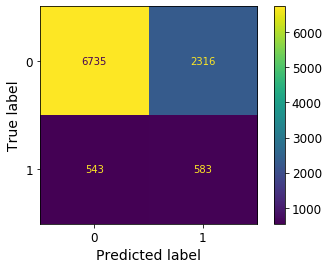

In [81]:
conf_mat = ConfusionMatrixDisplay.from_predictions(
    test_labels, 
    best_rf.predict_proba(test_data_prepared)[:,1] > 0.13)
conf_mat